In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import datetime as dt
import math

Se obtienen los datasets de entrenamiento y test y se los transforma en dataframes para su análisis.

In [2]:
df_train = pd.read_csv('bike_train.csv')
df_test = pd.read_csv('bike_test.csv')

In [3]:
df_test.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,12000,5/20/2012,2,1,5,4,0,0,0,1,0.52,0.5000,0.68,0.0896
1,12001,5/20/2012,2,1,5,5,0,0,0,1,0.50,0.4848,0.72,0.1045
2,12002,5/20/2012,2,1,5,6,0,0,0,1,0.50,0.4848,0.63,0.1343
3,12003,5/20/2012,2,1,5,7,0,0,0,1,0.52,0.5000,0.68,0.1940
4,12004,5/20/2012,2,1,5,8,0,0,0,1,0.56,0.5303,0.56,0.1642


In [116]:
df_train.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,1/1/2011,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,1/1/2011,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,1/1/2011,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,1/1/2011,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,1/1/2011,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


El dataset de test no posee la columna casual, registered ni cnt

Se transforma la columna fecha en un formato ordinal para ser utilizada posteriormente en los modelos elegidos

In [14]:
train = df_train.copy()
test = df_test.copy()
train.dteday = pd.to_datetime(train.dteday)
train.dteday = train.dteday.map(dt.datetime.toordinal)
test.dteday = pd.to_datetime(test.dteday)
test.dteday = test.dteday.map(dt.datetime.toordinal)

#### Analisis de outliers sobre variable objetivo

<AxesSubplot:xlabel='cnt', ylabel='Count'>

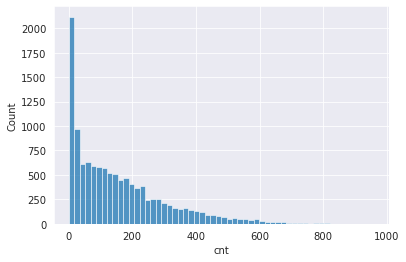

In [135]:
sns.histplot(train.cnt)

In [136]:
#No aplicar por el momento
'''Q1 = train['cnt'].quantile(0.25)
Q3 = train['cnt'].quantile(0.75)
IQR = Q3 - Q1
BI = Q1 - 1.5*IQR
BS = Q3 + 1.5*IQR
out = ((train['cnt']>BI) & (train['cnt']<BS))'''

In [137]:
'''train['out'] = out
train = train[train.out == True]
train = train.drop(columns=['out'])
train.head()'''

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,734138,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,734138,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,734138,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,734138,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,734138,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


<AxesSubplot:xlabel='cnt', ylabel='Count'>

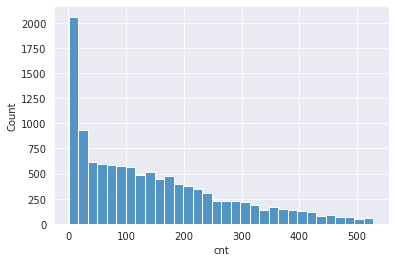

In [138]:
sns.histplot(train.cnt)

Después de quitar outliers se observa un peor resultado en hoja de calculo final

Se plantea la matriz de correlación correspondiente para observar la relación entre las distintas features

In [139]:
train.corr().style.background_gradient(cmap='Greens')

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,1.000000,0.999990,0.133540,0.766310,0.187138,-0.019501,0.011120,0.000339,0.009109,-0.006480,0.016888,0.029590,0.006937,-0.035348,0.050472,0.188989,0.169354
dteday,0.999990,1.000000,0.134788,0.765476,0.188414,-0.021538,0.011043,0.000369,0.009224,-0.006356,0.018124,0.030837,0.008005,-0.035655,0.050501,0.188562,0.169015
season,0.133540,0.134788,1.000000,-0.445753,0.865038,-0.009986,-0.008955,-0.001654,0.008844,-0.009781,0.416090,0.418673,0.203253,-0.145492,0.149519,0.120091,0.142938
yr,0.766310,0.765476,-0.445753,1.000000,-0.485470,-0.014252,0.003385,-0.010972,0.006386,0.002918,-0.219028,-0.211143,-0.127525,0.064525,-0.025580,0.107920,0.080346
mnth,0.187138,0.188414,0.865038,-0.485470,1.000000,-0.007621,0.009399,0.017690,0.003408,-0.014233,0.358892,0.364459,0.202994,-0.148268,0.110119,0.092796,0.108821
hr,-0.019501,-0.021538,-0.009986,-0.014252,-0.007621,1.000000,0.002896,-0.003900,-0.002728,-0.016519,0.121991,0.117624,-0.246387,0.126903,0.288766,0.401109,0.414068
holiday,0.011120,0.011043,-0.008955,0.003385,0.009399,0.002896,1.000000,-0.102413,-0.249678,-0.016681,-0.026849,-0.036218,-0.040431,0.022879,0.035576,-0.040860,-0.022633
weekday,0.000339,0.000369,-0.001654,-0.010972,0.017690,-0.003900,-0.102413,1.000000,0.037110,0.017978,-0.011323,-0.011204,-0.022309,0.007094,0.000526,0.020741,0.017078
workingday,0.009109,0.009224,0.008844,0.006386,0.003408,-0.002728,-0.249678,0.037110,1.000000,0.047333,0.058859,0.063085,0.026247,-0.005702,-0.306209,0.116744,0.003142
weathersit,-0.006480,-0.006356,-0.009781,0.002918,-0.014233,-0.016519,-0.016681,0.017978,0.047333,1.000000,-0.072074,-0.073708,0.429449,0.012429,-0.145627,-0.114583,-0.137274


A partir de lo observado se decide utilizar las features que aparecen a continuación y definir como variable objetivo la cantidad de bicicletas rentadas

In [15]:
x = train.drop(columns=['cnt', 'registered', 'casual', 'temp', 'mnth', 'yr', 'dteday'])
y = train.cnt
x_predecir = test.drop(columns=['temp', 'mnth', 'yr', 'dteday'])

Se dividen estos datos para poder realizar pruebas en cada uno de los modelos

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

### Se presentan análisis sobre disitintas soluciones o modelos para definir cuál es el que presenta un menor RMSE

#### Regresión Lineal Polinomial

In [41]:
poly_reg=PolynomialFeatures(degree=4)
X_poly=poly_reg.fit_transform(x_train)
poly_reg.fit(X_poly,y_train)
model_rlp=LinearRegression()
model_rlp.fit(X_poly,y_train)

LinearRegression()

In [46]:
x_train.shape

(9599, 10)

In [47]:
y_pred = model_rlp.predict(poly_reg.fit_transform(x_test))

In [48]:
RMSE_rlp = math.sqrt(mean_squared_error(y_test, y_pred))
RMSE_rlp

101.54667410334622

#### Decision Tree Regresor

In [93]:
tree_para = {'criterion':['squared_error']}
model_dtr = GridSearchCV(DecisionTreeRegressor(), tree_para, cv=5)

In [94]:
model_dtr.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['squared_error']})

In [95]:
model_dtr.cv_results_

{'mean_fit_time': array([0.03177729]),
 'std_fit_time': array([0.00891469]),
 'mean_score_time': array([0.00153542]),
 'std_score_time': array([2.20343144e-05]),
 'param_criterion': masked_array(data=['squared_error'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'criterion': 'squared_error'}],
 'split0_test_score': array([0.86275722]),
 'split1_test_score': array([0.88690157]),
 'split2_test_score': array([0.88518543]),
 'split3_test_score': array([0.88076273]),
 'split4_test_score': array([0.88393372]),
 'mean_test_score': array([0.87990813]),
 'std_test_score': array([0.00880735]),
 'rank_test_score': array([1], dtype=int32)}

In [96]:
y_pred = model_dtr.predict(x_test)
RMSE_dtr = math.sqrt(mean_squared_error(y_test, y_pred))
RMSE_dtr

49.651590273290005

#### Random Forest Regresor

In [63]:
randomf_para = {'criterion':['squared_error'],}
model_rfr = GridSearchCV(RandomForestRegressor(), randomf_para, cv=5)

In [64]:
model_rfr.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['squared_error']})

In [65]:
model_rfr.cv_results_

{'mean_fit_time': array([1.79936218, 2.74402251]),
 'std_fit_time': array([0.04229409, 0.01856241]),
 'mean_score_time': array([0.04043417, 0.04566956]),
 'std_score_time': array([0.00049366, 0.00170583]),
 'param_bootstrap': masked_array(data=[True, False],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_criterion': masked_array(data=['squared_error', 'squared_error'],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'bootstrap': True, 'criterion': 'squared_error'},
  {'bootstrap': False, 'criterion': 'squared_error'}],
 'split0_test_score': array([0.93721771, 0.89582473]),
 'split1_test_score': array([0.94434408, 0.89611149]),
 'split2_test_score': array([0.93855895, 0.88965121]),
 'split3_test_score': array([0.94161341, 0.8908916 ]),
 'split4_test_score': array([0.93818079, 0.8993592 ]),
 'mean_test_score': array([0.93998299, 0.89436765]),
 'std_test_score': array([0.00263059, 0.0035890

In [66]:
y_pred = model_rfr.predict(x_test)
RMSE = math.sqrt(mean_squared_error(y_test, y_pred))
RMSE

37.49494874757576

#### XGBRegressor

In [17]:
xgbr_para = {}
model_xgbr = GridSearchCV(XGBRegressor(), xgbr_para, cv=5)

In [18]:
model_xgbr.fit(x_train, y_train)

/home/jeo/anaconda3/envs/data/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jeo/anaconda3/envs/data/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jeo/anaconda3/envs/data/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jeo/anaconda3/envs/data/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_parameters=None, verbosity=None),
             param_grid={})

In [12]:
model_xgbr.cv_results_

{'mean_fit_time': array([0.58687043]),
 'std_fit_time': array([0.162152]),
 'mean_score_time': array([0.00437922]),
 'std_score_time': array([0.00423131]),
 'params': [{}],
 'split0_test_score': array([0.94695877]),
 'split1_test_score': array([0.94945908]),
 'split2_test_score': array([0.9515885]),
 'split3_test_score': array([0.94750595]),
 'split4_test_score': array([0.94714237]),
 'mean_test_score': array([0.94853093]),
 'std_test_score': array([0.00176978]),
 'rank_test_score': array([1], dtype=int32)}

In [19]:
y_pred = model_xgbr.predict(x_test)
RMSE_tree = math.sqrt(mean_squared_error(y_test, y_pred))
RMSE_tree

32.476110493880576

#### ALTERNATIVA DOBLE PREDICCION

Esta alternativa consiste en la elaboración de dos modelos para la predicción que se solicita. El primer modelo se encargara de predecir la feature casual que como se observa en la matriz de correlación presenta una relación bastante evidente con la variable objetivo cnt, pero el dataset de test no cuenta con ésta. Por este motivo en esta primera instancia se realiza esta acción. El segundo modelo se encarga de predecir la variable objetivo a partir del dataset de test mas la columna casual que se predijo con el primer modelo. Esta alternativa solo se realizó con el objetivo de ver el comportamiento de lo que se plantea y no asegura un resultado acorde

Dividir el dataset para realizar el entramiento correspondiente y realizar pruebas

In [20]:
x1 = train.drop(columns=['cnt', 'registered', 'casual', 'temp', 'mnth', 'yr', 'dteday'])
x2 = train.drop(columns=['cnt', 'registered', 'temp', 'mnth', 'yr', 'dteday'])
y2 = train.cnt
y1 = train.casual

In [21]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x1, y1, test_size=0.2)

Se utilizará para ambos modelos XGBRegressor() porque es el que presento mejor desempeño anteriormente

Entrenamiento de primer modelo

In [22]:
model1 = XGBRegressor()
model1.fit(x_train1, y_train1)
pred1 = model1.predict(x_test1)
e = mean_squared_error(y_test1, pred1)
math.sqrt(e)

/home/jeo/anaconda3/envs/data/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


10.863903673998902

Entrenamiento de segundo modelo

In [23]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.2)

In [24]:
model2 = XGBRegressor()
model2.fit(x_train2, y_train2)
pred2 = model2.predict(x_test2)
e = mean_squared_error(y_test2, pred2)
math.sqrt(e)

/home/jeo/anaconda3/envs/data/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


26.749869949097704

#### Probar Modelo

Con el modelo entrenado se procede a realizar pruebas para comprobar su rendimiento

In [25]:
x_test1['casual'] = pred1

In [26]:
pred_final = model2.predict(x_test1.sort_values(by=['instant']))

In [29]:
valores_finales = train[train.instant.isin(x_test1.instant)]
valores_finales

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,734138,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
11,12,734138,1,0,1,11,0,6,0,1,0.36,0.3333,0.81,0.2836,26,30,56
16,17,734138,1,0,1,16,0,6,0,2,0.42,0.4242,0.82,0.2985,41,52,93
19,20,734138,1,0,1,19,0,6,0,3,0.42,0.4242,0.88,0.2537,6,31,37
20,21,734138,1,0,1,20,0,6,0,2,0.40,0.4091,0.87,0.2537,11,25,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11960,11961,734641,2,1,5,13,0,5,1,1,0.64,0.6212,0.36,0.1642,98,297,395
11963,11964,734641,2,1,5,16,0,5,1,1,0.66,0.6212,0.34,0.2537,151,417,568
11966,11967,734641,2,1,5,19,0,5,1,1,0.62,0.6212,0.41,0.1940,91,392,483
11969,11970,734641,2,1,5,22,0,5,1,1,0.56,0.5303,0.52,0.3284,57,194,251


In [27]:
pred_final

array([ 21.381287,  52.71146 ,  67.28136 , ..., 526.2756  , 253.67523 ,
       681.31415 ], dtype=float32)

In [30]:
e = mean_squared_error(valores_finales.cnt, pred_final)
math.sqrt(e)

30.824260234278064

Se observa una leve disminución del modelo de XGBRegressor por si solo, pero no es significativo dicho cambio

In [31]:
prueba_pred_final = x_predecir.copy()

In [32]:
pred_final1 = model1.predict(prueba_pred_final)

In [33]:
prueba_pred_final['casual'] = pred_final1

In [34]:
pred_final2 = model2.predict(prueba_pred_final)
pred_final2

array([ 48.045937,  59.244724,  89.21494 , ..., 186.07112 , 119.6959  ,
        95.36211 ], dtype=float32)

Se decide utilizar XGBRegressor para predecir el resultado debido a su menor medida de RMSE

In [146]:
y_final = model_rfr.predict(x_predecir)

Se aplica valor absoluto a la predicción final para asegurar que no existan valores negativos

In [35]:
final = np.abs(pred_final2)

In [36]:
resultado = pd.DataFrame(final)
resultado = resultado.rename(columns={0: 'pred'})
resultado

,pred
0,48.045937
1,59.244724
2,89.214943
3,125.452354
4,239.138580
...,...
5375,344.157166
5376,227.641541
5377,186.071121
5378,119.695900


Exportar Resultado a csv

In [37]:
resultado.to_csv('jeo10.csv', index=False)